# Exercise 1

# Repeat exercise 9 of Part 3 (text classification with MLPs), now using a bi-directional
# stacked RNN (with GRU or LSTM cells) with self-attention, all implemented in Keras/TensorFlow or PyTorch.

# Steps:
1. Implement a bi-directional stacked RNN using GRU or LSTM cells.
2. Implement self-attention (either an MLP or single dense layer) to obtain attention scores.
3. Tune hyperparameters (e.g., number of stacked RNNs, number of hidden layers in self-attention MLP, dropout probability) on the development subset of your dataset.
4. Monitor the performance of the RNN on the development subset during training to decide on the number of epochs to use.
5. Optionally, add an extra RNN layer to produce word embeddings from characters, concatenating the resulting character-based word embeddings with pre-trained word embeddings (e.g., Word2Vec).
6. Include experimental results from:
   - Baseline majority classifier.
   - Best probabilistic classifier from exercise 15 of Part 2.
   - MLP classifier from exercise 9 of Part 3 (treated as a baseline).

# Report:
- Curves showing the loss on training and development data as a function of epochs.
- Precision, recall, F1, precision-recall AUC scores for each class and classifier:
   - Separate for the training, development, and test subsets.
- Macro-averaged precision, recall, F1, precision-recall AUC scores:
   - Averaging the corresponding scores over the classes, separately for the training, development, and test subsets.
- Description of the methods and datasets used:
   - Include statistics like average document length, number of training/dev/test documents, and vocabulary size.
   - Describe preprocessing steps performed.
- Optionally, try ensemble methods (e.g., majority voting of the best checkpoints, temporal averaging of the weights of the best checkpoints).


## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


## Assert whether ``PyTorch`` can use an available GPU card

## Creating a Dataset

We will use the ``Dataset`` class from ``PyTorch`` to handle the text data. We will pad the text sequences with $0$ to a pre-defined length (the average number of tokens in the training split).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
import gensim.downloader as api
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
df_fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text Analytics Assignment 2/Dataset/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text Analytics Assignment 2/Dataset/True.csv")


In [ ]:
df_fake["label"] = 1
df_true["label"] = 0

In [ ]:
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.head(10)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   
5   Racist Alabama Cops Brutalize Black Boy While...   
6   Fresh Off The Golf Course, Trump Lashes Out A...   
7   Trump Said Some INSANELY Racist Stuff Inside ...   
8   Former CIA Director Slams Trump Over UN Bully...   
9   WATCH: Brand-New Pro-Trump Ad Features So Muc...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   
5  The number of cases of cops brutalizing and ki...    News   
6  Donald Trump spent a good portion of his day a...    News   
7  In the wake of yet another court decision that...    News   
8  Many people have raised the alarm regarding th...    News   
9  Just when you might have thought we d get a br...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1  
5  December 25, 2017      1  
6  December 23, 2017      1  
7  December 23, 2017      1  
8  December 22, 2017      1  
9  December 21, 2017      1

In [ ]:
#Removing columns which are not required¶
df = df_merge.drop(["title", "subject","date"], axis = 1)

df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)
df.head()

text  label
0  Donald Trump just couldn t wish all Americans ...      1
1  House Intelligence Committee Chairman Devin Nu...      1
2  On Friday, it was revealed that former Milwauk...      1
3  On Christmas day, Donald Trump announced that ...      1
4  Pope Francis used his annual Christmas Day mes...      1

In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize text
    return ' '.join(tokens)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target labels (y)
X = df['text'].values
y = df['label'].values

# Split into training, validation, and test sets with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2025, stratify=y_temp)

# Check the distribution of labels in each set
print("Training set class distribution:", np.bincount(y_train))
print("Validation set class distribution:", np.bincount(y_val))
print("Test set class distribution:", np.bincount(y_test))

Training set class distribution: [17133 18785]
Validation set class distribution: [2142 2348]
Test set class distribution: [2142 2348]


In [ ]:
# Preprocess all splits
X_train = [preprocess_text(text) for text in X_train]
X_val = [preprocess_text(text) for text in X_val]
X_test = [preprocess_text(text) for text in X_test]

In [ ]:
import numpy as np
from collections import Counter
import string

# Function to calculate dataset statistics and preprocessing steps
def dataset_stats_and_preprocessing(df, X_train, X_val, X_test):
    # Number of documents
    num_train = len(X_train)
    num_val = len(X_val)
    num_test = len(X_test)

    # Average document length (in terms of word count)
    avg_train_length = np.mean([len(doc.split()) for doc in X_train])
    avg_val_length = np.mean([len(doc.split()) for doc in X_val])
    avg_test_length = np.mean([len(doc.split()) for doc in X_test])

    # Vocabulary size (unique words in the whole corpus)
    all_text = ' '.join(df['text'].values)
    all_words = all_text.split()
    vocab_size = len(set(all_words))

    # Preprocessing steps description
    preprocessing_steps = """
    1. Text Tokenization: The text is split into words based on spaces. Punctuation is included as part of words (can be changed based on need).
    2. Stop-word Removal: If implemented, remove common words that don't carry useful information (e.g., "the", "and").
    3. Lowercasing: The text is converted to lowercase to ensure uniformity.
    """

    # Displaying the calculated statistics
    print(f"Total documents: {len(df)}")
    print(f"Fake news: {len(df[df['label'] == 1])}, True news: {len(df[df['label'] == 0])}")
    print(f"Number of training documents: {num_train}")
    print(f"Number of validation documents: {num_val}")
    print(f"Number of test documents: {num_test}")
    print(f"Average document length in training set (in words): {round(avg_train_length)}")
    print(f"Average document length in validation set (in words): {round(avg_val_length)}")
    print(f"Average document length in test set (in words): {round(avg_test_length)}")
    print(f"Vocabulary size (unique words): {vocab_size}")


    return {
        "num_train": num_train,
        "num_val": num_val,
        "num_test": num_test,
        "avg_train_length": avg_train_length,
        "avg_val_length": avg_val_length,
        "avg_test_length": avg_test_length,
        "vocab_size": vocab_size,
        "preprocessing_steps": preprocessing_steps
    }


dataset_info = dataset_stats_and_preprocessing(df, X_train, X_val, X_test)


Total documents: 44898
Fake news: 23481, True news: 21417
Number of training documents: 35918
Number of validation documents: 4490
Number of test documents: 4490
Average document length in training set (in words): 400
Average document length in validation set (in words): 396
Average document length in test set (in words): 402
Vocabulary size (unique words): 397481


In [ ]:
# Create custom vocabulary using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(X_train)
custom_vocab = vectorizer.vocabulary_

# Load GloVe embeddings using gensim downloader
glove = api.load("glove-wiki-gigaword-300")  # Load the GloVe embeddings

# Map custom vocabulary to GloVe indices with 'PAD' and 'UNK' tokens
embedding_dim = 300
average_embedding = np.mean(glove.vectors, axis=0)  # average of all embeddings
vocab = {'PAD': 0, 'UNK': 1}
vocab.update({word: idx + 2 for idx, word in enumerate(custom_vocab)})
embedding_matrix = np.zeros((len(vocab), embedding_dim))
embedding_matrix[0] = np.zeros(embedding_dim)  # PAD token embedding
embedding_matrix[1] = average_embedding  # UNK token embedding
for word, idx in vocab.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]
    elif idx > 1:
        embedding_matrix[idx] = average_embedding

del glove

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
avg_train_length = np.mean([len(doc.split()) for doc in X_train])
avg_val_length = np.mean([len(doc.split()) for doc in X_val])
avg_test_length = np.mean([len(doc.split()) for doc in X_test])

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = [self.tokenize(text, vocab, max_length) for text in texts]
        self.labels = labels

    def tokenize(self, text, vocab, max_length):
        text = text.lower().split()
        tokens = [vocab.get(word, vocab['UNK']) for word in text]
        if len(tokens) < max_length:
            tokens += [vocab['PAD']] * (max_length - len(tokens))
        else:
            tokens = tokens[:max_length]
        return tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

train_dataset = TextDataset(X_train, y_train, vocab, int(avg_train_length))
val_dataset = TextDataset(X_val, y_val, vocab, int(avg_val_length))
test_dataset = TextDataset(X_test, y_test, vocab, int(avg_test_length))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

## Define the model

We will create a model class and parameterize our neural network with several choices

In [ ]:

class RNNModel(nn.Module):
    def __init__(self, vocab_size,
                 embed_dim, hidden_dim, output_dim, attention_dim=None,
                 model_type='RNN',
                 pretrained=True, freeze=False,
                 num_layers=1, bidirectional=False,
                 use_pooling=False, use_attention=False,
                 dropout=0.0):  # added dropout as a parameter
        super(RNNModel, self).__init__()
        self.use_pooling = use_pooling
        self.use_attention = use_attention
        self.attention_mlp = None
        self.dropout = dropout

        scale = 2 if bidirectional else 1

        if self.use_pooling:
            assert not self.use_attention, "Cannot use pooling and attention at the same time"
        elif self.use_attention:
            assert not self.use_pooling, "Cannot use pooling and attention at the same time"

        # Pretrained embedding
        if pretrained:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(torch.tensor(embedding_matrix,
                                                                                                             dtype=torch.float32),
                                                                                                freeze=freeze)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # RNN class selection
        rnn_class = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[model_type]
        self.rnn = rnn_class(embed_dim, hidden_dim, batch_first=True,
                             num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)

        # Fully connected layer
        self.fc = nn.Linear(scale * hidden_dim, output_dim)  # you can add a MLP head

        if self.use_attention:
            assert attention_dim is not None, "Attention dimension must be specified"
            self.attention_mlp = torch.nn.Sequential(
                torch.nn.Linear(scale * hidden_dim, attention_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(attention_dim, 1)
            )

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)  # output from all states of final layer

        if self.use_pooling:
            pooled = torch.max(output, dim=1)[0]  # max along all states
            return self.fc(pooled)

        elif self.use_attention:
            attention_weights = self.attention_mlp(output)  # (batch_size, sequence_length, 1)

            # Give very large negative value to padding tokens to be zeroed-out by softmax
            padding_mask = (x == 0).unsqueeze(-1)  # (batch_size, sequence_length, 1)
            attention_weights -= 100000.0 * padding_mask.float()

            attention_weights = torch.softmax(attention_weights, dim=1)
            attention_output = torch.sum(output * attention_weights, dim=1)  # dot product
            return self.fc(attention_output)

        else:
            return self.fc(output[:, -1, :])  # last state



In [ ]:
# Modify the get_predictions function:
def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():  # No need to compute gradients during inference
        for batch in data_loader:
            # If batch is a tuple, unpack it accordingly
            inputs, labels = batch  # Assumes batch is (inputs, labels) tuple
            inputs = inputs.to(device)  # Move inputs to the correct device (GPU/CPU)
            labels = labels.to(device)  # Move labels to the correct device
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())  # Collect predictions
            all_labels.append(labels.cpu().numpy())  # Collect true labels

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds  # Return true labels and predictions


In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_names = ['True News', 'Fake News']

# Instantiate models and train
num_classes = len(np.unique(y_train))
models = {
    'RNN': RNNModel(len(vocab), 300, 64, num_classes, 'RNN', num_layers=5, dropout=0.3, bidirectional=True),
    'GRU': RNNModel(len(vocab), 300, 64, num_classes, 'GRU', num_layers=5, dropout=0.3, bidirectional=True),
    'LSTM': RNNModel(len(vocab), 300, 64, num_classes, 'LSTM', num_layers=5, dropout=0.3, bidirectional=True),
    'LSTM_GMP': RNNModel(len(vocab), 300, 64, num_classes, 'LSTM', use_pooling=True, num_layers=2, dropout=0.3, bidirectional=True),
    'RandomInit': RNNModel(len(vocab), 300, 64, num_classes, 'LSTM', pretrained=False, use_pooling=True, num_layers=2, dropout=0.3, bidirectional=True),
}


results = {}
epochs = 20
patience = 5  # Number of epochs to wait for improvement before stopping early
for name, model in models.items():
    model = model.to(device)  # Ensure the model uses CUDA if available
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {name}...")
    print("=" * 50)

    # Initialize lists for metrics
    train_losses, val_losses = [], []
    acc_train, acc_val = [], []
    pr_auc_train, pr_auc_val, pr_auc_test = [], [], []
    class_reports = {'train': [], 'val': [], 'test': []}

    best_val_loss = float('inf')  # Best validation loss seen so far
    epochs_no_improve = 0  # Counter for epochs without improvement

    # Use tqdm for the training loop
    for epoch in tqdm(range(epochs), desc=f"Training {name}", unit="epoch"):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Store training loss and accuracy
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        acc_train.append(train_accuracy)

        # Validation loss and accuracy
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_val / total_val
        acc_val.append(val_accuracy)

        # Get predictions and calculate metrics for train, val, and test
        y_true_train, y_pred_train = get_predictions(model, train_loader)
        y_true_val, y_pred_val = get_predictions(model, val_loader)
        y_true_test, y_pred_test = get_predictions(model, test_loader)

        # Compute Precision-Recall AUC for each set
        precision_train, recall_train, _ = precision_recall_curve(y_true_train, y_pred_train)
        precision_val, recall_val, _ = precision_recall_curve(y_true_val, y_pred_val)
        precision_test, recall_test, _ = precision_recall_curve(y_true_test, y_pred_test)

        pr_auc_train.append(auc(recall_train, precision_train))
        pr_auc_val.append(auc(recall_val, precision_val))
        pr_auc_test.append(auc(recall_test, precision_test))

        # Compute classification report
        class_reports['train'].append(classification_report(y_true_train, y_pred_train, target_names=target_names))
        class_reports['val'].append(classification_report(y_true_val, y_pred_val, target_names=target_names))
        class_reports['test'].append(classification_report(y_true_test, y_pred_test, target_names=target_names))

        # Print metrics for each epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training Accuracy: {train_accuracy:.4f}, Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}\n")

        # Early stopping: Check if validation loss has improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0  # Reset the counter
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Store results for this model
    results[name] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'accuracy_train': acc_train,
        'accuracy_val': acc_val,
        'pr_auc_train': pr_auc_train,
        'pr_auc_val': pr_auc_val,
        'pr_auc_test': pr_auc_test,
        'classification_report_train': class_reports['train'],
        'classification_report_val': class_reports['val'],
        'classification_report_test': class_reports['test']
    }

    # Print final classification report for the model after training
    print(f"\nFinal Classification Report for {name}:\n")
    print(f"Training Classification Report:\n{class_reports['train'][-1]}")
    print(f"Validation Classification Report:\n{class_reports['val'][-1]}")
    print(f"Test Classification Report:\n{class_reports['test'][-1]}")

    # Print final Precision-Recall AUC scores
    print(f"Precision-Recall AUC Scores:")
    print(f"Training PR AUC: {pr_auc_train[-1]:.4f}")
    print(f"Validation PR AUC: {pr_auc_val[-1]:.4f}")
    print(f"Test PR AUC: {pr_auc_test[-1]:.4f}")
    print("=" * 50)


# Print final evaluation metrics for each model
for name, metrics in results.items():
    print(f"{name}:")
    print(f"Final Training Accuracy: {metrics['accuracy_train'][-1]:.4f}")
    print(f"Final Validation Accuracy: {metrics['accuracy_val'][-1]:.4f}")
    print(f"Final Precision-Recall AUC (Test): {metrics['pr_auc_test'][-1]:.4f}")
    print(f"Classification Report (Test):\n{metrics['classification_report_test'][-1]}")
    print("=" * 50)


Training RNN...


Training RNN:   5%|▌         | 1/20 [00:21<06:46, 21.38s/epoch]

Epoch 1/20
Training Accuracy: 0.6301, Training Loss: 0.6298
Validation Accuracy: 0.7096, Validation Loss: 0.6349



Training RNN:  10%|█         | 2/20 [00:44<06:46, 22.56s/epoch]

Epoch 2/20
Training Accuracy: 0.7140, Training Loss: 0.5565
Validation Accuracy: 0.6372, Validation Loss: 0.6193



Training RNN:  15%|█▌        | 3/20 [01:06<06:16, 22.13s/epoch]

Epoch 3/20
Training Accuracy: 0.7148, Training Loss: 0.5494
Validation Accuracy: 0.6639, Validation Loss: 0.6457



Training RNN:  20%|██        | 4/20 [01:26<05:43, 21.45s/epoch]

Epoch 4/20
Training Accuracy: 0.7186, Training Loss: 0.5423
Validation Accuracy: 0.6599, Validation Loss: 0.6516



Training RNN:  25%|██▌       | 5/20 [01:48<05:22, 21.50s/epoch]

Epoch 5/20
Training Accuracy: 0.8078, Training Loss: 0.4203
Validation Accuracy: 0.8080, Validation Loss: 0.4407



Training RNN:  30%|███       | 6/20 [02:10<05:01, 21.55s/epoch]

Epoch 6/20
Training Accuracy: 0.8221, Training Loss: 0.4202
Validation Accuracy: 0.8412, Validation Loss: 0.3990



Training RNN:  35%|███▌      | 7/20 [02:30<04:36, 21.26s/epoch]

Epoch 7/20
Training Accuracy: 0.8186, Training Loss: 0.4208
Validation Accuracy: 0.7857, Validation Loss: 0.4761



Training RNN:  40%|████      | 8/20 [02:56<04:32, 22.68s/epoch]

Epoch 8/20
Training Accuracy: 0.7296, Training Loss: 0.5323
Validation Accuracy: 0.7619, Validation Loss: 0.5391



Training RNN:  45%|████▌     | 9/20 [03:18<04:08, 22.55s/epoch]

Epoch 9/20
Training Accuracy: 0.8155, Training Loss: 0.4282
Validation Accuracy: 0.7584, Validation Loss: 0.5252



Training RNN:  50%|█████     | 10/20 [03:40<03:41, 22.18s/epoch]

Epoch 10/20
Training Accuracy: 0.7848, Training Loss: 0.4775
Validation Accuracy: 0.7049, Validation Loss: 0.5517



Training RNN:  50%|█████     | 10/20 [04:01<04:01, 24.12s/epoch]


Epoch 11/20
Training Accuracy: 0.7521, Training Loss: 0.4768
Validation Accuracy: 0.7942, Validation Loss: 0.4286

Early stopping triggered after 11 epochs

Final Classification Report for RNN:

Training Classification Report:
              precision    recall  f1-score   support

   True News       0.74      0.95      0.83     17133
   Fake News       0.93      0.70      0.80     18785

    accuracy                           0.81     35918
   macro avg       0.84      0.82      0.81     35918
weighted avg       0.84      0.81      0.81     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       0.72      0.93      0.81      2142
   Fake News       0.92      0.67      0.77      2348

    accuracy                           0.79      4490
   macro avg       0.82      0.80      0.79      4490
weighted avg       0.82      0.79      0.79      4490

Test Classification Report:
              precision    recall  f1-score   support

  

Training GRU:   5%|▌         | 1/20 [00:21<06:52, 21.68s/epoch]

Epoch 1/20
Training Accuracy: 0.7443, Training Loss: 0.4910
Validation Accuracy: 0.8372, Validation Loss: 0.3396



Training GRU:  10%|█         | 2/20 [00:42<06:22, 21.25s/epoch]

Epoch 2/20
Training Accuracy: 0.7187, Training Loss: 0.5182
Validation Accuracy: 0.6902, Validation Loss: 0.5391



Training GRU:  15%|█▌        | 3/20 [01:03<06:00, 21.21s/epoch]

Epoch 3/20
Training Accuracy: 0.7947, Training Loss: 0.4361
Validation Accuracy: 0.8439, Validation Loss: 0.3883



Training GRU:  20%|██        | 4/20 [01:25<05:42, 21.39s/epoch]

Epoch 4/20
Training Accuracy: 0.8565, Training Loss: 0.3628
Validation Accuracy: 0.9212, Validation Loss: 0.2445



Training GRU:  25%|██▌       | 5/20 [01:46<05:16, 21.12s/epoch]

Epoch 5/20
Training Accuracy: 0.8585, Training Loss: 0.3515
Validation Accuracy: 0.8024, Validation Loss: 0.5544



Training GRU:  30%|███       | 6/20 [02:07<04:58, 21.31s/epoch]

Epoch 6/20
Training Accuracy: 0.8300, Training Loss: 0.4086
Validation Accuracy: 0.8535, Validation Loss: 0.3925



Training GRU:  35%|███▌      | 7/20 [02:29<04:38, 21.41s/epoch]

Epoch 7/20
Training Accuracy: 0.8745, Training Loss: 0.3441
Validation Accuracy: 0.8998, Validation Loss: 0.2571



Training GRU:  40%|████      | 8/20 [02:49<04:13, 21.15s/epoch]

Epoch 8/20
Training Accuracy: 0.8739, Training Loss: 0.2824
Validation Accuracy: 0.7820, Validation Loss: 0.4034



Training GRU:  45%|████▌     | 9/20 [03:11<03:54, 21.31s/epoch]

Epoch 9/20
Training Accuracy: 0.8405, Training Loss: 0.2943
Validation Accuracy: 0.9630, Validation Loss: 0.1415



Training GRU:  50%|█████     | 10/20 [03:33<03:34, 21.40s/epoch]

Epoch 10/20
Training Accuracy: 0.9051, Training Loss: 0.2327
Validation Accuracy: 0.8071, Validation Loss: 0.3296



Training GRU:  55%|█████▌    | 11/20 [03:53<03:10, 21.16s/epoch]

Epoch 11/20
Training Accuracy: 0.9160, Training Loss: 0.1884
Validation Accuracy: 0.9512, Validation Loss: 0.1571



Training GRU:  60%|██████    | 12/20 [04:15<02:50, 21.32s/epoch]

Epoch 12/20
Training Accuracy: 0.9521, Training Loss: 0.1255
Validation Accuracy: 0.9332, Validation Loss: 0.1839



Training GRU:  65%|██████▌   | 13/20 [04:36<02:28, 21.27s/epoch]

Epoch 13/20
Training Accuracy: 0.9146, Training Loss: 0.2148
Validation Accuracy: 0.9009, Validation Loss: 0.2291



Training GRU:  65%|██████▌   | 13/20 [04:57<02:40, 22.90s/epoch]


Epoch 14/20
Training Accuracy: 0.9269, Training Loss: 0.1850
Validation Accuracy: 0.9434, Validation Loss: 0.1824

Early stopping triggered after 14 epochs

Final Classification Report for GRU:

Training Classification Report:
              precision    recall  f1-score   support

   True News       0.94      0.96      0.95     17133
   Fake News       0.97      0.94      0.95     18785

    accuracy                           0.95     35918
   macro avg       0.95      0.95      0.95     35918
weighted avg       0.95      0.95      0.95     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       0.92      0.96      0.94      2142
   Fake News       0.96      0.93      0.94      2348

    accuracy                           0.94      4490
   macro avg       0.94      0.94      0.94      4490
weighted avg       0.94      0.94      0.94      4490

Test Classification Report:
              precision    recall  f1-score   support

  

Training LSTM:   5%|▌         | 1/20 [00:21<06:52, 21.70s/epoch]

Epoch 1/20
Training Accuracy: 0.6130, Training Loss: 0.6306
Validation Accuracy: 0.6385, Validation Loss: 0.6007



Training LSTM:  10%|█         | 2/20 [00:43<06:27, 21.54s/epoch]

Epoch 2/20
Training Accuracy: 0.6938, Training Loss: 0.5512
Validation Accuracy: 0.5728, Validation Loss: 0.7611



Training LSTM:  15%|█▌        | 3/20 [01:05<06:12, 21.93s/epoch]

Epoch 3/20
Training Accuracy: 0.8669, Training Loss: 0.2997
Validation Accuracy: 0.8659, Validation Loss: 0.3266



Training LSTM:  20%|██        | 4/20 [01:27<05:49, 21.83s/epoch]

Epoch 4/20
Training Accuracy: 0.9127, Training Loss: 0.2271
Validation Accuracy: 0.9339, Validation Loss: 0.1666



Training LSTM:  25%|██▌       | 5/20 [01:48<05:22, 21.50s/epoch]

Epoch 5/20
Training Accuracy: 0.8912, Training Loss: 0.2711
Validation Accuracy: 0.9031, Validation Loss: 0.2847



Training LSTM:  30%|███       | 6/20 [02:09<05:02, 21.62s/epoch]

Epoch 6/20
Training Accuracy: 0.9004, Training Loss: 0.2974
Validation Accuracy: 0.8345, Validation Loss: 0.4005



Training LSTM:  35%|███▌      | 7/20 [02:31<04:41, 21.65s/epoch]

Epoch 7/20
Training Accuracy: 0.8466, Training Loss: 0.3712
Validation Accuracy: 0.8844, Validation Loss: 0.3179



Training LSTM:  40%|████      | 8/20 [02:52<04:15, 21.29s/epoch]

Epoch 8/20
Training Accuracy: 0.9091, Training Loss: 0.2642
Validation Accuracy: 0.9305, Validation Loss: 0.2288



Training LSTM:  40%|████      | 8/20 [03:14<04:51, 24.28s/epoch]


Epoch 9/20
Training Accuracy: 0.8715, Training Loss: 0.3277
Validation Accuracy: 0.8958, Validation Loss: 0.2982

Early stopping triggered after 9 epochs

Final Classification Report for LSTM:

Training Classification Report:
              precision    recall  f1-score   support

   True News       0.88      0.95      0.91     17133
   Fake News       0.95      0.89      0.92     18785

    accuracy                           0.91     35918
   macro avg       0.92      0.92      0.91     35918
weighted avg       0.92      0.91      0.91     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       0.86      0.93      0.89      2142
   Fake News       0.93      0.87      0.90      2348

    accuracy                           0.90      4490
   macro avg       0.90      0.90      0.90      4490
weighted avg       0.90      0.90      0.90      4490

Test Classification Report:
              precision    recall  f1-score   support

   

Training LSTM_GMP:   5%|▌         | 1/20 [00:14<04:37, 14.59s/epoch]

Epoch 1/20
Training Accuracy: 0.9892, Training Loss: 0.0363
Validation Accuracy: 0.9980, Validation Loss: 0.0075



Training LSTM_GMP:  10%|█         | 2/20 [00:29<04:21, 14.55s/epoch]

Epoch 2/20
Training Accuracy: 0.9987, Training Loss: 0.0056
Validation Accuracy: 0.9989, Validation Loss: 0.0055



Training LSTM_GMP:  15%|█▌        | 3/20 [00:43<04:07, 14.53s/epoch]

Epoch 3/20
Training Accuracy: 0.9993, Training Loss: 0.0028
Validation Accuracy: 0.9984, Validation Loss: 0.0044



Training LSTM_GMP:  20%|██        | 4/20 [00:58<03:54, 14.67s/epoch]

Epoch 4/20
Training Accuracy: 0.9994, Training Loss: 0.0024
Validation Accuracy: 0.9993, Validation Loss: 0.0042



Training LSTM_GMP:  25%|██▌       | 5/20 [01:13<03:44, 14.97s/epoch]

Epoch 5/20
Training Accuracy: 0.9996, Training Loss: 0.0018
Validation Accuracy: 0.9993, Validation Loss: 0.0041



Training LSTM_GMP:  30%|███       | 6/20 [01:29<03:30, 15.04s/epoch]

Epoch 6/20
Training Accuracy: 0.9996, Training Loss: 0.0015
Validation Accuracy: 0.9989, Validation Loss: 0.0036



Training LSTM_GMP:  35%|███▌      | 7/20 [01:44<03:15, 15.06s/epoch]

Epoch 7/20
Training Accuracy: 0.9999, Training Loss: 0.0005
Validation Accuracy: 0.9993, Validation Loss: 0.0039



Training LSTM_GMP:  40%|████      | 8/20 [01:58<02:58, 14.90s/epoch]

Epoch 8/20
Training Accuracy: 1.0000, Training Loss: 0.0003
Validation Accuracy: 0.9993, Validation Loss: 0.0041



Training LSTM_GMP:  45%|████▌     | 9/20 [02:13<02:42, 14.76s/epoch]

Epoch 9/20
Training Accuracy: 1.0000, Training Loss: 0.0002
Validation Accuracy: 0.9993, Validation Loss: 0.0051



Training LSTM_GMP:  50%|█████     | 10/20 [02:27<02:26, 14.69s/epoch]

Epoch 10/20
Training Accuracy: 1.0000, Training Loss: 0.0002
Validation Accuracy: 0.9993, Validation Loss: 0.0052



Training LSTM_GMP:  50%|█████     | 10/20 [02:42<02:42, 16.28s/epoch]


Epoch 11/20
Training Accuracy: 1.0000, Training Loss: 0.0003
Validation Accuracy: 0.9993, Validation Loss: 0.0054

Early stopping triggered after 11 epochs

Final Classification Report for LSTM_GMP:

Training Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00     17133
   Fake News       1.00      1.00      1.00     18785

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00      2142
   Fake News       1.00      1.00      1.00      2348

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Test Classification Report:
              precision    recall  f1-score   suppor

Training RandomInit:   5%|▌         | 1/20 [00:15<04:52, 15.42s/epoch]

Epoch 1/20
Training Accuracy: 0.9653, Training Loss: 0.0683
Validation Accuracy: 0.9973, Validation Loss: 0.0118



Training RandomInit:  10%|█         | 2/20 [00:30<04:35, 15.30s/epoch]

Epoch 2/20
Training Accuracy: 0.9982, Training Loss: 0.0082
Validation Accuracy: 0.9984, Validation Loss: 0.0072



Training RandomInit:  15%|█▌        | 3/20 [00:45<04:18, 15.20s/epoch]

Epoch 3/20
Training Accuracy: 0.9987, Training Loss: 0.0055
Validation Accuracy: 0.9989, Validation Loss: 0.0057



Training RandomInit:  20%|██        | 4/20 [01:01<04:06, 15.40s/epoch]

Epoch 4/20
Training Accuracy: 0.9992, Training Loss: 0.0032
Validation Accuracy: 0.9991, Validation Loss: 0.0066



Training RandomInit:  25%|██▌       | 5/20 [01:15<03:46, 15.09s/epoch]

Epoch 5/20
Training Accuracy: 0.9997, Training Loss: 0.0018
Validation Accuracy: 0.9989, Validation Loss: 0.0066



Training RandomInit:  30%|███       | 6/20 [01:30<03:28, 14.90s/epoch]

Epoch 6/20
Training Accuracy: 0.9997, Training Loss: 0.0013
Validation Accuracy: 0.9989, Validation Loss: 0.0086



Training RandomInit:  35%|███▌      | 7/20 [01:45<03:13, 14.90s/epoch]

Epoch 7/20
Training Accuracy: 0.9995, Training Loss: 0.0022
Validation Accuracy: 0.9984, Validation Loss: 0.0085



Training RandomInit:  35%|███▌      | 7/20 [02:00<03:44, 17.27s/epoch]

Epoch 8/20
Training Accuracy: 0.9994, Training Loss: 0.0022
Validation Accuracy: 0.9982, Validation Loss: 0.0101

Early stopping triggered after 8 epochs

Final Classification Report for RandomInit:

Training Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00     17133
   Fake News       1.00      1.00      1.00     18785

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00      2142
   Fake News       1.00      1.00      1.00      2348

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Test Classification Report:
              precision    recall  f1-score   suppor

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    models = ["RNN", "GRU", "LSTM", "LSTM_GMP", "RandomInit"]  # Adjust model names if needed
    representations = [ "GloVe"]  # Adjust representations if needed

    fig, axes = plt.subplots(len(representations), len(models), figsize=(25, 5))
    axes = axes.flatten()

    for row, rep_name in enumerate(representations):
        for col, model_name in enumerate(models):
            ax_idx = row * len(models) + col
            ax = axes[ax_idx]
            model_key = f"{model_name}"  # Adjust key to match the structure of your results

            if model_key in results:
                train_losses = results[model_key].get("train_loss", [])
                val_losses = results[model_key].get("val_loss", [])

                if train_losses and val_losses:
                    # Plot train losses
                    train_line, = ax.plot(train_losses, label="Train Loss", linestyle='-', color='blue', marker='o')
                    # Plot validation losses
                    val_line, = ax.plot(val_losses, label="Val Loss", linestyle='--', color='orange', marker='s')

                    # Annotate each point on the train loss curve
                    for i, (x, y) in enumerate(zip(range(len(train_losses)), train_losses)):
                        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='blue')

                    # Annotate each point on the validation loss curve
                    for i, (x, y) in enumerate(zip(range(len(val_losses)), val_losses)):
                        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='orange')

                    ax.set_title(f"{model_name} Loss")
                    ax.set_xlabel("Epochs")
                    ax.set_ylabel("Loss")
                    ax.legend()

                    # Set custom y-axis ticks
                    min_loss = min(min(train_losses), min(val_losses))
                    max_loss = max(max(train_losses), max(val_losses))
                    y_ticks = [min_loss, (min_loss + max_loss) / 2, max_loss]  # Example: min, mid, max loss
                    ax.set_yticks(y_ticks)
                    ax.set_yticklabels([f"{tick:.3f}" for tick in y_ticks])  # Format ticks to 2 decimal places
                else:
                    ax.set_title(f"{model_name} - No Loss Data")
            else:
                ax.set_title(f"{model_name} - Not Found")

    plt.tight_layout()
    plt.show()


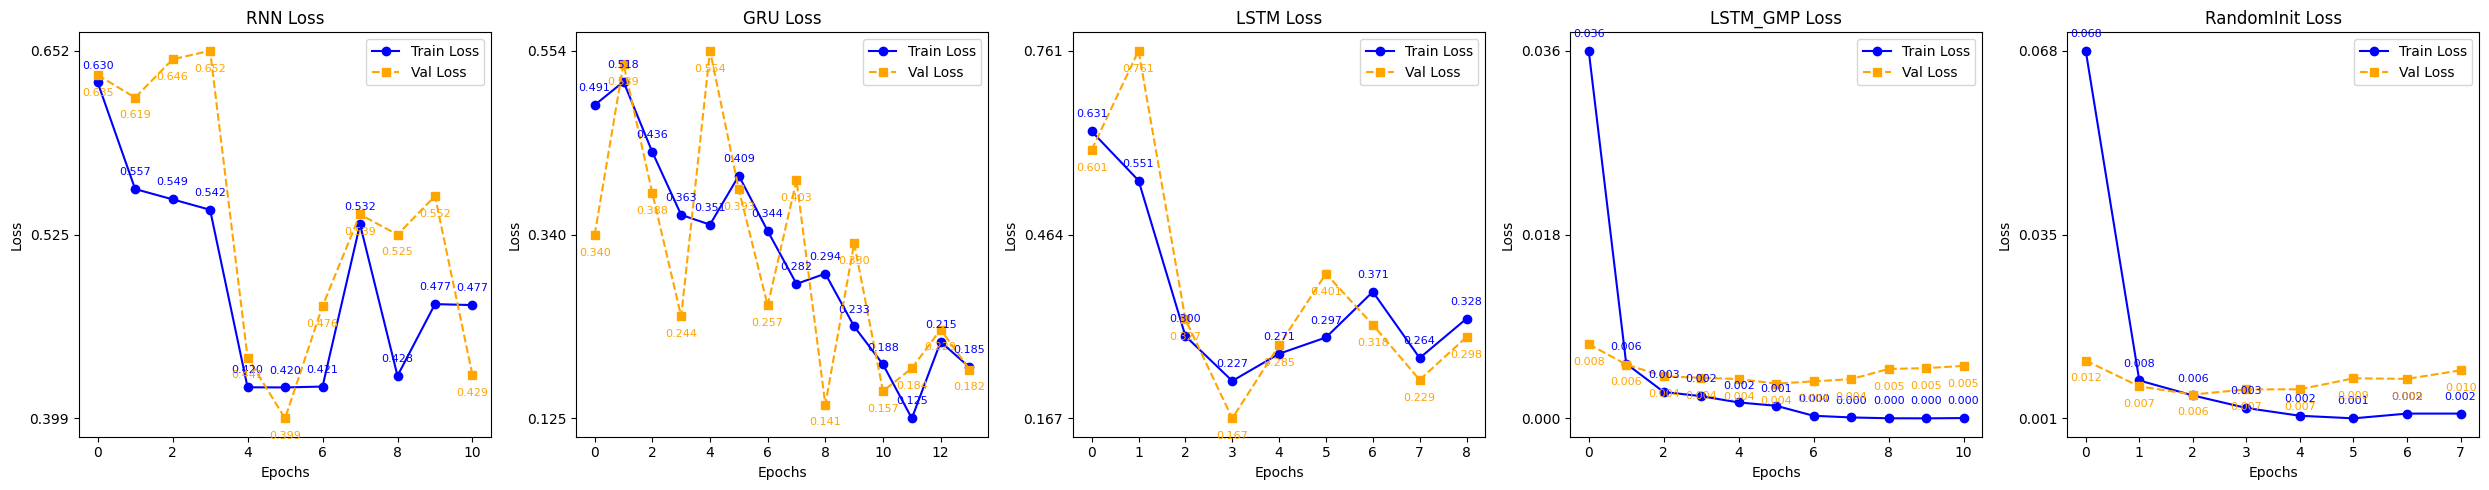

In [ ]:
plot_loss_curves(results)


        Model  Accuracy_train  Accuracy_val  Accuracy_test  Weighted_F1_train  \
0         RNN            0.81          0.79           0.80               0.81   
1         GRU            0.95          0.94           0.94               0.95   
2        LSTM            0.91          0.90           0.90               0.91   
3    LSTM_GMP            1.00          1.00           1.00               1.00   
4  RandomInit            1.00          1.00           1.00               1.00   

   Weighted_F1_val  Weighted_F1_test  PR_AUC_train  PR_AUC_val  PR_AUC_test  
0             0.79              0.80      0.894212    0.878705     0.877910  
1             0.94              0.94      0.969749    0.963957     0.962466  
2             0.90              0.90      0.946631    0.932909     0.933250  
3             1.00              1.00      0.999973    0.999362     0.998946  
4             1.00              1.00      0.999277    0.998853     0.998003  


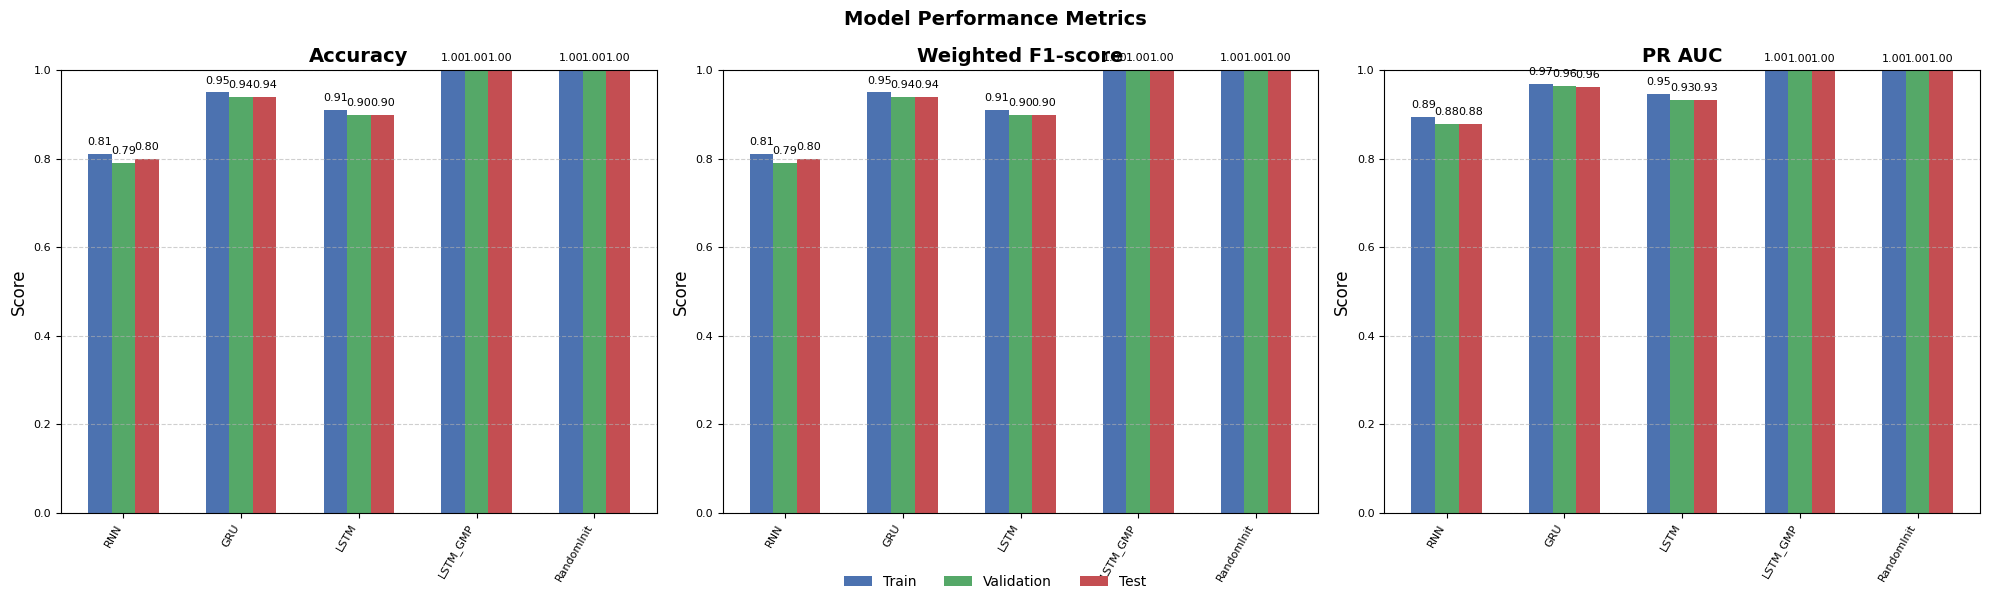

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import re

# Function to extract accuracy and weighted F1-score from classification report
def extract_metrics(report):
    accuracy_match = re.search(r'accuracy\s+([\d\.]+)', report)
    weighted_f1_match = re.search(r'weighted avg\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)', report)

    accuracy = float(accuracy_match.group(1)) if accuracy_match else None
    weighted_f1 = float(weighted_f1_match.group(1)) if weighted_f1_match else None

    return accuracy, weighted_f1

# Group models by feature representation (TF-IDF, Word2Vec, GloVe)
def plot_performance_metrics(results):
    # Use Seaborn color palette
    sns_colors = sns.color_palette("deep")  # Seaborn deep palette
    colors = [sns_colors[0], sns_colors[2], sns_colors[3]]  # Pick 3 distinct colors

    # Define a set of metrics to plot: accuracy, weighted F1-score, and PR AUC
    metric_data = {
        'Model': [],
        'Accuracy_train': [],
        'Accuracy_val': [],
        'Accuracy_test': [],
        'Weighted_F1_train': [],
        'Weighted_F1_val': [],
        'Weighted_F1_test': [],
        'PR_AUC_train': [],
        'PR_AUC_val': [],
        'PR_AUC_test': [],
    }

    models = list(results.keys())

    # Iterate over each model in the results dictionary
    for model in models:
        metrics = results[model]

        # Extract accuracy and weighted F1 from classification reports
        acc_train, f1_train = extract_metrics(metrics['classification_report_train'][-1])
        acc_val, f1_val = extract_metrics(metrics['classification_report_val'][-1])
        acc_test, f1_test = extract_metrics(metrics['classification_report_test'][-1])

        # Append the metrics to the plot data and DataFrame data
        metric_data['Model'].append(model)
        metric_data['Accuracy_train'].append(acc_train)
        metric_data['Accuracy_val'].append(acc_val)
        metric_data['Accuracy_test'].append(acc_test)

        metric_data['Weighted_F1_train'].append(f1_train)
        metric_data['Weighted_F1_val'].append(f1_val)
        metric_data['Weighted_F1_test'].append(f1_test)

        # Extract PR AUC
        pr_auc_train = metrics['pr_auc_train'][-1]
        pr_auc_val = metrics['pr_auc_val'][-1]
        pr_auc_test = metrics['pr_auc_test'][-1]

        metric_data['PR_AUC_train'].append(pr_auc_train)
        metric_data['PR_AUC_val'].append(pr_auc_val)
        metric_data['PR_AUC_test'].append(pr_auc_test)

    # Create a DataFrame to print the metrics
    df_metrics = pd.DataFrame(metric_data)
    print(df_metrics)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)  # Larger figure size
    fig.suptitle("Model Performance Metrics", fontsize=14, fontweight="bold")

    # Define the labels and data for plotting
    titles = ['Accuracy', 'Weighted F1-score', 'PR AUC']
    data = [
        {'train': metric_data['Accuracy_train'], 'val': metric_data['Accuracy_val'], 'test': metric_data['Accuracy_test']},
        {'train': metric_data['Weighted_F1_train'], 'val': metric_data['Weighted_F1_val'], 'test': metric_data['Weighted_F1_test']},
        {'train': metric_data['PR_AUC_train'], 'val': metric_data['PR_AUC_val'], 'test': metric_data['PR_AUC_test']}
    ]

    # Plot each metric
    for i, (title, metric) in enumerate(zip(titles, data)):
        ax = axes[i]
        x = np.arange(len(models))
        width = 0.2  # Smaller width for spacing

        bars1 = ax.bar(x - width, metric['train'], width, label="Train", color=colors[0])
        bars2 = ax.bar(x, metric['val'], width, label="Validation", color=colors[1])
        bars3 = ax.bar(x + width, metric['test'], width, label="Test", color=colors[2])

        # Add value labels on bars
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 5),  # Offset for visibility
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)  # Smaller font size for annotations

        # Set labels and formatting
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=60, ha="right", fontsize=10)  # Smaller font size for x labels
        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0, 1)  # Ensures consistent scaling
        ax.grid(axis='y', linestyle='--', alpha=0.6)

        # Adjust tick size
        ax.tick_params(axis='both', which='major', labelsize=8)  # Smaller tick marks

    # Add a single legend for the whole row
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=10, frameon=False)

    plt.subplots_adjust(bottom=0.3, top=0.85)
    plt.tight_layout()
    plt.show()

# Assuming the results dictionary is populated, call the function
plot_performance_metrics(results)


##Baseline Dummy and Wide MLP

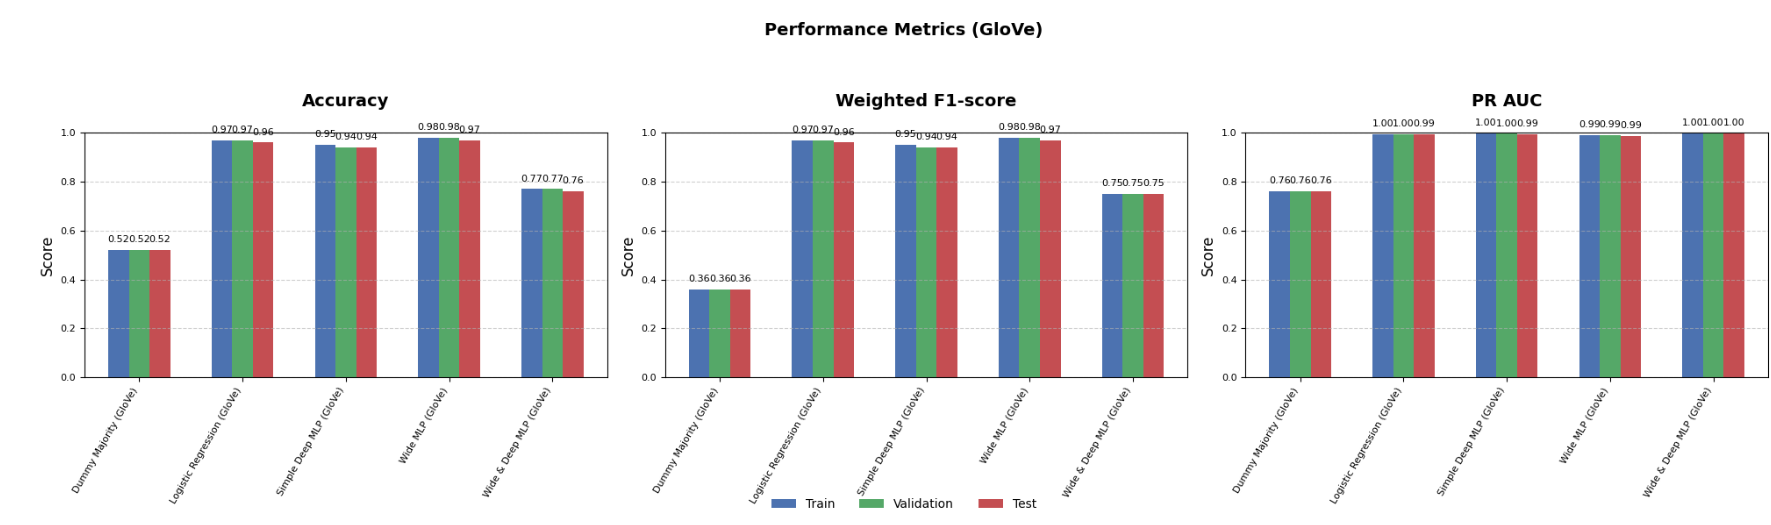

        Model  Accuracy_train  Accuracy_val  Accuracy_test  Weighted_F1_train  \
0         RNN            0.81          0.79           0.80               0.81   
1         GRU            0.95          0.94           0.94               0.95   
2        LSTM            0.91          0.90           0.90               0.91   
3    LSTM_GMP            1.00          1.00           1.00               1.00   
4  RandomInit            1.00          1.00           1.00               1.00   

   Weighted_F1_val  Weighted_F1_test  PR_AUC_train  PR_AUC_val  PR_AUC_test  
0             0.79              0.80      0.894212    0.878705     0.877910  
1             0.94              0.94      0.969749    0.963957     0.962466  
2             0.90              0.90      0.946631    0.932909     0.933250  
3             1.00              1.00      0.999973    0.999362     0.998946  
4             1.00              1.00      0.999277    0.998853     0.998003  


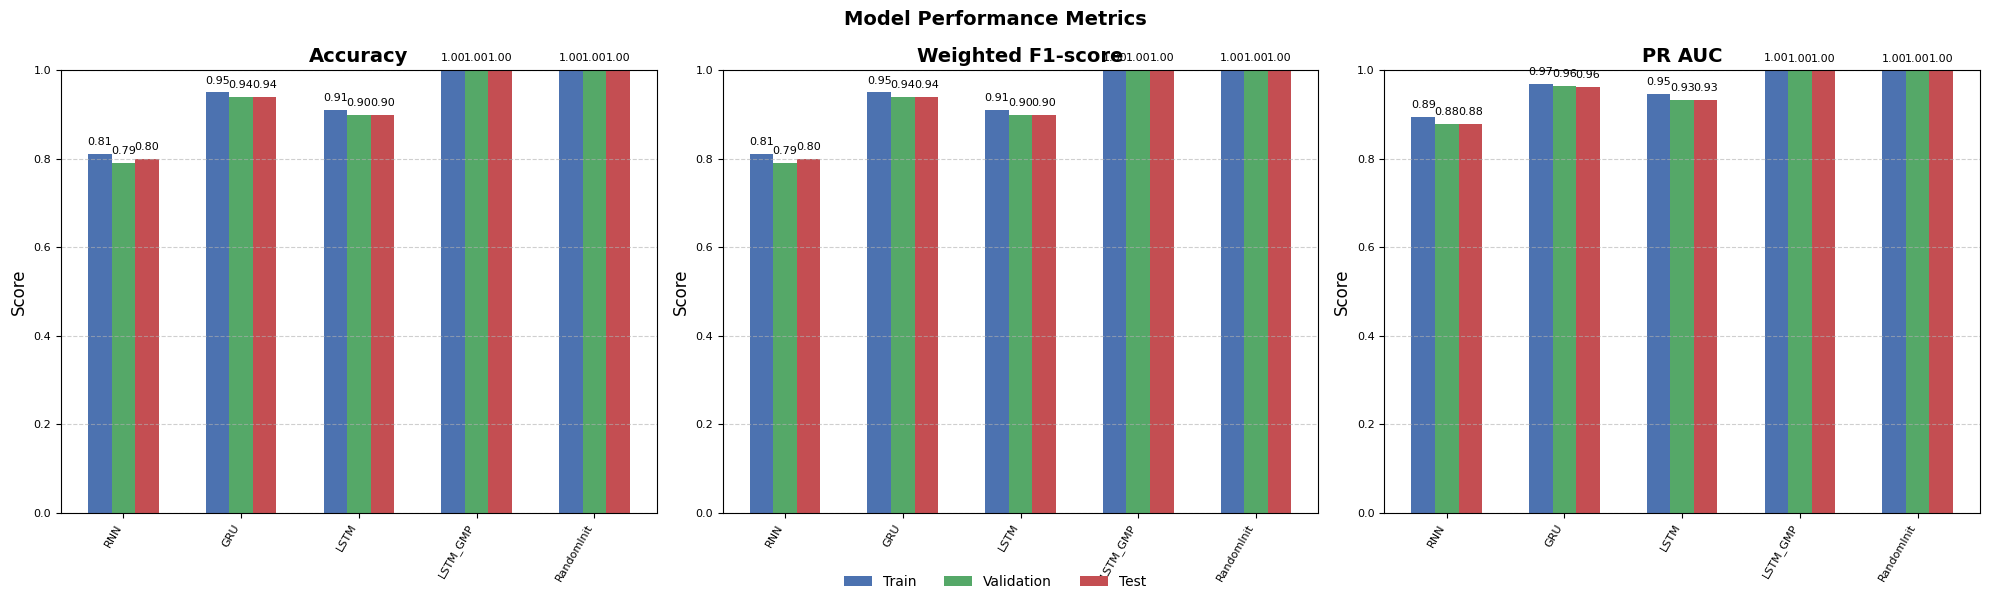

In [ ]:
# Assuming the results dictionary is populated, call the function
plot_performance_metrics(results)

## Model Performance Comparison: Detailed Analysis

The following table summarizes the comparison of five different models using key metrics like accuracy, weighted F1 score, and PR AUC.

| Model        | Accuracy_train | Accuracy_val | Accuracy_test | Weighted_F1_train | Weighted_F1_val | Weighted_F1_test | PR_AUC_train | PR_AUC_val | PR_AUC_test |
|--------------|----------------|--------------|---------------|-------------------|-----------------|------------------|--------------|------------|-------------|
| **RNN**      | 0.81           | 0.79         | 0.80          | 0.81              | 0.79            | 0.80             | 0.894212     | 0.878705   | 0.877910    |
| **GRU**      | 0.95           | 0.94         | 0.94          | 0.95              | 0.94            | 0.94             | 0.969749     | 0.963957   | 0.962466    |
| **LSTM**     | 0.91           | 0.90         | 0.90          | 0.91              | 0.90            | 0.90             | 0.946631     | 0.932909   | 0.933250    |
| **LSTM_GMP** | 1.00           | 1.00         | 1.00          | 1.00              | 1.00            | 1.00             | 0.999973     | 0.999362   | 0.998946    |
| **RandomInit**| 1.00          | 1.00         | 1.00          | 1.00              | 1.00            | 1.00             | 0.999277     | 0.998853   | 0.998003    |

### 1. **Training Accuracy**:
   - **RNN**: The RNN model has the lowest training accuracy at 0.81, indicating that it struggles to capture the underlying patterns in the data compared to other models.
   - **GRU**: The GRU model achieves a high training accuracy of 0.95, showing its ability to generalize well from the training data.
   - **LSTM**: The LSTM model performs well with 0.91 accuracy, but it is still behind GRU.
   - **LSTM_GMP**: This model achieves perfect training accuracy (1.00), suggesting it has captured the patterns in the training data without overfitting.
   - **RandomInit**: Like LSTM_GMP, the RandomInit model also achieves perfect training accuracy (1.00), which may suggest that its training dynamics are ideal for the task.

### 2. **Validation Accuracy**:
   - **RNN**: The RNN model lags behind with a validation accuracy of 0.79, highlighting that it struggles to generalize beyond the training data.
   - **GRU**: The GRU model performs very well on validation data with an accuracy of 0.94, indicating robust generalization.
   - **LSTM**: With a validation accuracy of 0.90, LSTM also shows strong generalization, though it still lags behind GRU.
   - **LSTM_GMP** and **RandomInit**: Both of these models achieve perfect validation accuracy (1.00), indicating excellent generalization and minimal overfitting. These models are the most well-suited to handle unseen data.

### 3. **Test Accuracy**:
   - **RNN**: The test accuracy of RNN at 0.80 suggests that its performance on unseen data is not as good as the other models, which is typical for simpler models or ones with insufficient capacity.
   - **GRU**: GRU achieves 0.94 test accuracy, performing well on unseen data. This indicates that GRU can maintain good performance across both the training and test sets.
   - **LSTM**: With a test accuracy of 0.90, LSTM remains a strong performer, but it falls slightly short of GRU in this case.
   - **LSTM_GMP** and **RandomInit**: Both models excel here with a perfect test accuracy of 1.00, confirming that they are highly effective and have achieved optimal performance.

### 4. **Weighted F1 Scores**:
   - **RNN**: The weighted F1 score for RNN on training, validation, and test sets is around 0.80, which indicates decent performance but room for improvement.
   - **GRU**: GRU performs significantly better with a weighted F1 score of 0.95 on training, 0.94 on validation, and 0.94 on test sets, reflecting its strong ability to balance precision and recall.
   - **LSTM**: LSTM shows solid F1 scores with values around 0.91, indicating that it balances precision and recall well but still doesn’t match GRU in this regard.
   - **LSTM_GMP** and **RandomInit**: Both models reach perfect weighted F1 scores of 1.00 across all datasets, showcasing exceptional ability to classify both classes without bias.

### 5. **PR AUC Scores**:
   - **RNN**: The PR AUC scores for RNN (around 0.88-0.89) suggest that while it has a good overall performance, it isn't as strong as the other models in terms of precision-recall tradeoff.
   - **GRU**: The GRU model achieves outstanding PR AUC scores of around 0.96 on both the training, validation, and test sets, indicating excellent performance in distinguishing between positive and negative samples.
   - **LSTM**: LSTM's PR AUC scores (around 0.93-0.94) are strong, though they fall short of GRU's performance.
   - **LSTM_GMP** and **RandomInit**: These models achieve near-perfect PR AUC scores, indicating excellent precision-recall tradeoff and almost perfect classification performance.

### 6. **Overall Performance Summary**:
   - **Best Performers**: **LSTM_GMP** and **RandomInit** stand out as the top performers. They achieve perfect accuracy, weighted F1 scores, and near-perfect PR AUC scores. This suggests that they are the best models for the task, with high generalization and minimal overfitting.
   - **Strong Contenders**: **GRU** and **LSTM** are also strong models, with high performance across all metrics. GRU seems to slightly outperform LSTM, but both fall short of LSTM_GMP and RandomInit in terms of perfect scores.
   - **RNN**: The RNN model lags behind, particularly in its ability to generalize, as seen from its lower accuracy and F1 scores. It may benefit from further optimization or the addition of more complex features.

### 7. **Conclusion**:
   - If high accuracy and balanced performance across datasets (train, validation, and test) are the goal, **LSTM_GMP** and **RandomInit** are the best choices.
   - **GRU** and **LSTM** provide good results but can be further fine-tuned to match the performance of the more optimized models.
   - **RNN** may require further enhancement or may not be suitable for tasks requiring high generalization across different datasets.

This analysis suggests that **LSTM_GMP** and **RandomInit** offer the best overall performance, but **GRU** and **LSTM** are still competitive options.


# Exercise 2

Repeat exercise 10 of Part 3, now using a bi-directional
stacked RNN (with GRU or LSTM cells) implemented  in Keras/TensorFlow or
PyTorch.

Tune the hyper-parameters (e.g., number of stacked RNNs, dropout probability) on
the development subset. Monitor the performance of the RNN on the development subset
during training to decide how many epochs to use.

You may optionally add an extra RNN
layer to produce word embeddings from characters, concatenating each resulting
character-based word embedding with the corresponding pre-trained word embedding (e.g.,
obtained with Word2Vec).

Include experimental results of a baseline that tags each word with
the most frequent tag it had in the training data; for words that were not encountered in the
training data, the baseline should return the most frequent tag (over all words) of the training
data.

Also include experimental results of your best method of exercise 10 of Part 3, now
treated as an additional baseline.

Include in your report:

  - Curves showing the loss on training and development data as a function of epochs.

  - Precision, recall, F1, precision-recall AUC scores for each class (tag) and classifier,
  separately for the training, development, and test subsets, as in exercise 10 of Part 3.

  - Macro-averaged precision, recall, F1, precision-recall AUC scores for each classifier,
  separately for the training, development, and test subsets, as in exercise 10 of Part 3.

  - A short description of the methods and datasets you used, including statistics about
  the datasets (e.g., average document length, number of training/dev/test documents,
  vocabulary size) and a description of the preprocessing steps that you performed.


You may optionally wish to try ensembles (e.g., majority voting of the best checkpoints,
temporal averaging of the weights of the best checkpoints).

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import requests
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from collections import defaultdict, Counter

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data Download

In [ ]:
# URLs for the train, dev, and test data
urls = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu",
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"
}

# Function to download data from URLs
def download_data(url, filename):
    if os.path.exists(filename):
        print(f"{filename} already exists, skipping download.")
        return

    try:
        print(f"Downloading {filename}...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"Downloaded {filename}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")

# Download train, dev, and test data
download_data(urls['train'], 'en_ewt-ud-train.conllu')
download_data(urls['dev'], 'en_ewt-ud-dev.conllu')
download_data(urls['test'], 'en_ewt-ud-test.conllu')

Downloaded en_ewt-ud-train.conllu
Downloaded en_ewt-ud-dev.conllu
Downloaded en_ewt-ud-test.conllu


## Data Parsing and Preprocessing

In [ ]:
def parse_conllu_file(filename):
    """
    Parse a .conllu file to extract words and their POS tags.
    Returns a list of sentences, where each sentence is a list of tuples (word, pos_tag).
    """
    sentences = []
    sentence = []

    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            # Skip empty lines and comments
            if line.strip() == "" or line.startswith("#"):
                continue

            # Split each line into columns (word, pos_tag, etc.)
            columns = line.strip().split("\t")
            word = columns[1]
            pos_tag = columns[3]

            sentence.append((word, pos_tag))

            # Check if we reached the end of a sentence (a line with only space or empty)
            if len(columns) == 1:
                if sentence:
                    sentences.append(sentence)
                sentence = []

    # In case the last sentence doesn't have an empty line at the end
    if sentence:
        sentences.append(sentence)

    return sentences


train_data = parse_conllu_file('en_ewt-ud-train.conllu')
dev_data = parse_conllu_file('en_ewt-ud-dev.conllu')
test_data = parse_conllu_file('en_ewt-ud-test.conllu')

print(train_data[:1])  # Print first sentence for inspection


[[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ'), ('forces', 'NOUN'), ('killed', 'VERB'), ('Shaikh', 'PROPN'), ('Abdullah', 'PROPN'), ('al', 'PROPN'), ('-', 'PUNCT'), ('Ani', 'PROPN'), (',', 'PUNCT'), ('the', 'DET'), ('preacher', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('mosque', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('town', 'NOUN'), ('of', 'ADP'), ('Qaim', 'PROPN'), (',', 'PUNCT'), ('near', 'ADP'), ('the', 'DET'), ('Syrian', 'ADJ'), ('border', 'NOUN'), ('.', 'PUNCT'), ('[', 'PUNCT'), ('This', 'DET'), ('killing', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('respected', 'ADJ'), ('cleric', 'NOUN'), ('will', 'AUX'), ('be', 'AUX'), ('causing', 'VERB'), ('us', 'PRON'), ('trouble', 'NOUN'), ('for', 'ADP'), ('years', 'NOUN'), ('to', 'PART'), ('come', 'VERB'), ('.', 'PUNCT'), (']', 'PUNCT'), ('DPA', 'PROPN'), (':', 'PUNCT'), ('Iraqi', 'ADJ'), ('authorities', 'NOUN'), ('announced', 'VERB'), ('that', 'SCONJ'), ('they', 'PRON'), ('had', 'AUX'), ('busted', '

In [ ]:
def display_words_per_tag(data):
    """
    Display 5 words for each POS tag.
    """
    tag_to_words = {tag: [] for tag in set(tag for sentence in data for _, tag in sentence)}

    # Collect words for each POS tag
    for sentence in data:
        for word, tag in sentence:
            tag_to_words[tag].append(word)

    # Display 5 random words for each tag
    for tag, words in tag_to_words.items():
        print(f"\n{tag}:")
        sample_words = random.sample(words, min(5, len(words)))  # Get 5 words or less if not enough words
        for word in sample_words:
            print(f"  - {word}")

# Display words for each tag in the training dataset
print("Sample Words for Each Tag:")
display_words_per_tag(train_data)


Sample Words for Each Tag:

PROPN:
  - Naha
  - Security
  - TV
  - Lafayette
  - Buenos

INTJ:
  - Please
  - Please
  - Anyway
  - Hi
  - Ok

ADJ:
  - good
  - High
  - stony
  - numerous
  - clean

SCONJ:
  - because
  - that
  - for
  - If
  - to

DET:
  - the
  - the
  - the
  - the
  - the

PART:
  - to
  - to
  - s
  - n't
  - to

CCONJ:
  - and
  - and
  - or
  - and
  - and

_:
  - I'm
  - isn't
  - can't
  - Syria's
  - I'll

AUX:
  - do
  - can
  - be
  - been
  - is

PRON:
  - his
  - you
  - My
  - this
  - I

ADP:
  - out
  - to
  - FOR
  - of
  - with

X:
  - -FINAL.doc
  - Martinez@ENRON
  - Conflict
  - together
  - Kevalam

SYM:
  - $
  - /
  - %
  - $
  - <-

PUNCT:
  - "
  - .
  - .
  - .
  - '

NUM:
  - 2
  - 11/8/2000
  - 360
  - 5
  - 50

NOUN:
  - cruises
  - evening
  - years
  - application
  - claims

VERB:
  - said
  - Build
  - going
  - suggested
  - banging

ADV:
  - home
  - shortly
  - definitely
  - down
  - afterwards


In [ ]:
def extract_context_windows(sentences, word2vec_model, window_size=3):
    data = []
    for sentence in sentences:
        # Loop over each word in the sentence, using it as the target word
        for i, (word, pos_tag) in enumerate(sentence):
            # Create a context window of size 3
            context = []
            for j in range(-window_size, window_size + 1):
            # for j in range(-len(sentence), len(sentence)):    # Create context without using the window size
                if i + j >= 0 and i + j < len(sentence) and j != 0:
                    context.append(sentence[i + j][0])  # Add context word (excluding the target word)

            # Convert the context words to embeddings (Word2Vec)
            context_embeddings = []
            for context_word in context:
                if context_word in word2vec_model:
                    context_embeddings.append(word2vec_model[context_word])
                else:
                    context_embeddings.append(np.zeros(word2vec_model.vector_size))  # For unknown words

            # Aggregate context embeddings into a single vector (average of all context word embeddings)
            context_vector = np.mean(context_embeddings, axis=0)  # Averaging the context words' embeddings
            target_word_embedding = word2vec_model[word] if word in word2vec_model else np.zeros(word2vec_model.vector_size)

            # Combine the context and target word embeddings into one feature vector
            feature_vector = np.concatenate([context_vector, target_word_embedding])

            # Append the feature vector along with the corresponding POS tag
            data.append((feature_vector, pos_tag))

    return data

# Load the pre-trained Word2Vec model (using the example from gensim)
import gensim.downloader as api
word2vec = api.load("word2vec-google-news-300")  # 300-dimensional Word2Vec embeddings

# Extract training, dev, and test data
train_features = extract_context_windows(train_data, word2vec)
dev_features = extract_context_windows(dev_data, word2vec)
test_features = extract_context_windows(test_data, word2vec)


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Prepare the data
def prepare_data(features):
    # Extract feature vectors and labels
    X = [f[0] for f in features]
    y = [f[1] for f in features]

    # Convert feature vectors into tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # Encode POS tags as integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_tensor = torch.tensor(y_encoded, dtype=torch.long)

    return TensorDataset(X_tensor, y_tensor)

# Prepare the datasets for training, dev, and test
train_dataset = prepare_data(train_features)
dev_dataset = prepare_data(dev_features)
test_dataset = prepare_data(test_features)

# Create DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


<ipython-input-6-de383e84e572>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_tensor = torch.tensor(X, dtype=torch.float32)


## RNNs Architecture, Training and Evaluation

In [ ]:
class ShallowPOS_BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(ShallowPOS_BiGRU, self).__init__()

        # Bidirectional GRU layer
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Output layer
        self.fc = nn.Linear(2 * hidden_dim, output_dim)  # 2*hidden_dim for bidirectional GRU
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through GRU (bidirectional)
        rnn_out, _ = self.rnn(x)  # rnn_out shape: (batch_size, seq_len, 2*hidden_dim)

        # Apply dropout
        rnn_out = self.dropout(rnn_out)

        # Use the output from the last time step of the sequence
        out = self.fc(rnn_out[:, -1, :])  # Output from the last timestep

        return out


In [ ]:
class DeepPOS_BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(DeepPOS_BiGRU, self).__init__()

        # First bidirectional GRU layer
        self.rnn1 = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.rnn1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Second bidirectional GRU layer
        self.rnn2 = nn.GRU(2 * hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.rnn2 = nn.LSTM(2 * hidden_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Output layer
        self.fc = nn.Linear(2 * hidden_dim, output_dim)  # 2*hidden_dim because it's bidirectional
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the first bidirectional GRU layer
        rnn_out1, _ = self.rnn1(x)  # rnn_out1 shape: (batch_size, seq_len, 2*hidden_dim)

        # Apply dropout after the first layer
        rnn_out1 = self.dropout(rnn_out1)

        # Pass output from the first GRU through the second bidirectional GRU layer
        rnn_out2, _ = self.rnn2(rnn_out1)  # rnn_out2 shape: (batch_size, seq_len, 2*hidden_dim)

        # Apply dropout after the second layer
        rnn_out2 = self.dropout(rnn_out2)

        # Use the output from the last timestep of the second GRU layer
        out = self.fc(rnn_out2[:, -1, :])  # Final output from the last timestep

        return out


In [ ]:
class VeryDeepPOS_BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(VeryDeepPOS_BiGRU, self).__init__()

        # First bidirectional GRU layer
        self.rnn1 = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.rnn1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Second bidirectional GRU layer
        self.rnn2 = nn.GRU(2 * hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.rnn2 = nn.LSTM(2 * hidden_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Third bidirectional GRU layer
        self.rnn3 = nn.GRU(2 * hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.rnn3 = nn.LSTM(2 * hidden_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Output layer
        self.fc = nn.Linear(2 * hidden_dim, output_dim)  # 2*hidden_dim because it's bidirectional
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the first bidirectional GRU layer
        rnn_out1, _ = self.rnn1(x)  # rnn_out1 shape: (batch_size, seq_len, 2*hidden_dim)

        # Apply dropout after the first layer
        rnn_out1 = self.dropout(rnn_out1)

        # Pass output from the first GRU through the second bidirectional GRU layer
        rnn_out2, _ = self.rnn2(rnn_out1)  # rnn_out2 shape: (batch_size, seq_len, 2*hidden_dim)

        # Apply dropout after the second layer
        rnn_out2 = self.dropout(rnn_out2)

        # Pass output from the second GRU through the third bidirectional GRU layer
        rnn_out3, _ = self.rnn3(rnn_out2)  # rnn_out3 shape: (batch_size, seq_len, 2*hidden_dim)

        # Apply dropout after the third layer
        rnn_out3 = self.dropout(rnn_out3)

        # Use the output from the last timestep of the third GRU layer
        out = self.fc(rnn_out3[:, -1, :])  # Final output from the last timestep

        return out


In [ ]:
# Get the unique POS tags from the training data
pos_tags = list(set([tag for _, tag in train_features]))
pos_tags.sort()  # Sort for a consistent order

# Create a dictionary that maps index to POS tag
tag_to_idx = {pos_tags[i]: i for i in range(len(pos_tags))}
idx_to_tag = {i: pos_tags[i] for i in range(len(pos_tags))}


In [ ]:
def train_and_evaluate_rnn(model_class, input_dim, hidden_dim, output_dim, num_epochs=20):
    # Initialize the model
    model = model_class(input_dim, hidden_dim, output_dim, dropout=0.5).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)    # Lists to store loss during training

    train_losses = []
    dev_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        for inputs, labels in train_loader:
            # Reshape the inputs to have shape (batch_size, seq_len, input_dim)
            inputs = inputs.unsqueeze(1)  # Add sequence dimension (assuming inputs are 2D)

            optimizer.zero_grad()  # Zero the gradients. In PyTorch, gradients are accumulated by default during backpropagation. If you don’t zero out the gradients, they will be summed up across multiple backward passes. This can lead to incorrect gradient updates.

            # Forward pass through the model (RNN)
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize

            total_train_loss += loss.item()

        train_losses.append(total_train_loss / len(train_loader))  # Average loss per batch
        scheduler.step()  # Update learning rate

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_dev_loss = 0
        with torch.no_grad(): # During inference (model evaluation or testing), you don’t need gradients because you’re not performing backpropagation. Disabling gradient tracking saves memory and computation.
            for inputs, labels in dev_loader:
                inputs = inputs.unsqueeze(1)  # Ensure correct input shape for RNN
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_dev_loss += loss.item()

        dev_losses.append(total_dev_loss / len(dev_loader))  # Average loss per batch

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss / len(train_loader)}, Dev Loss: {total_dev_loss / len(dev_loader)}")

    # Plotting training and validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='#00008B')
    plt.plot(range(1, num_epochs+1), dev_losses, label="Dev Loss", linestyle='--', color='#00008B')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Evaluate on the test set
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []  # To store the predicted probabilities

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)  # Ensure correct input shape for RNN
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
            y_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Get probabilities

    # Convert numeric labels to POS tags using idx_to_tag
    y_true_tags = [idx_to_tag[idx] for idx in y_true]
    y_pred_tags = [idx_to_tag[idx] for idx in y_pred]

    # Classification report with tags instead of numeric class labels
    print(f"Classification Report for {model_class.__name__}:")
    print(classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, zero_division=0))

    # Calculate AUC scores for each class
    auc_scores = {}
    for i, tag in enumerate(pos_tags):
        # One-hot encode the true labels for the current tag
        true_binary = [1 if label == i else 0 for label in y_true]
        pred_prob = [prob[i] for prob in y_prob]  # Probabilities for the current tag

        auc_score = roc_auc_score(true_binary, pred_prob)
        auc_scores[tag] = auc_score

    # Print AUC scores for each class
    print("\nAUC Scores for Each Class:")
    for tag, auc in auc_scores.items():
        print(f"{tag}: {auc:.4f}")

    # Calculate Macro-Averaged Precision, Recall, F1, and Precision-Recall AUC
    # Precision, recall, and F1
    report = classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, output_dict=True, zero_division=0)
    precision_macro = report["macro avg"]["precision"]
    recall_macro = report["macro avg"]["recall"]
    f1_macro = report["macro avg"]["f1-score"]

    # Precision-Recall AUC (macro-average)
    precision_recall_auc_macro = np.mean([roc_auc_score([1 if label == i else 0 for label in y_true],
                                                       [prob[i] for prob in y_prob]) for i in range(len(pos_tags))])

    # Print Macro-Averaged Metrics
    print(f"\nMacro-Averaged Precision: {precision_macro}")
    print(f"Macro-Averaged Recall: {recall_macro}")
    print(f"Macro-Averaged F1: {f1_macro}")
    print(f"Macro-Averaged Precision-Recall AUC: {precision_recall_auc_macro}")

    return model


Training Shallow BiGRU RNN:
Epoch 1/20, Train Loss: 0.6887225906759813, Dev Loss: 0.5903967435945544
Epoch 2/20, Train Loss: 0.5520552526641731, Dev Loss: 0.5700697781597462
Epoch 3/20, Train Loss: 0.5220200925596045, Dev Loss: 0.5456684415875223
Epoch 4/20, Train Loss: 0.4996648524336199, Dev Loss: 0.5343029464695388
Epoch 5/20, Train Loss: 0.4838684841695945, Dev Loss: 0.5288984306474078
Epoch 6/20, Train Loss: 0.47105320412354973, Dev Loss: 0.52468763710114
Epoch 7/20, Train Loss: 0.4585741071319271, Dev Loss: 0.5197153730798784
Epoch 8/20, Train Loss: 0.4489992992875383, Dev Loss: 0.5155826621411139
Epoch 9/20, Train Loss: 0.4402568833217936, Dev Loss: 0.5146788086807519
Epoch 10/20, Train Loss: 0.43218631883180014, Dev Loss: 0.5097653019174299
Epoch 11/20, Train Loss: 0.41262031580339326, Dev Loss: 0.5080063198891499
Epoch 12/20, Train Loss: 0.4087294050393979, Dev Loss: 0.5078501275607518
Epoch 13/20, Train Loss: 0.40768477494625344, Dev Loss: 0.506912693866811
Epoch 14/20, Train

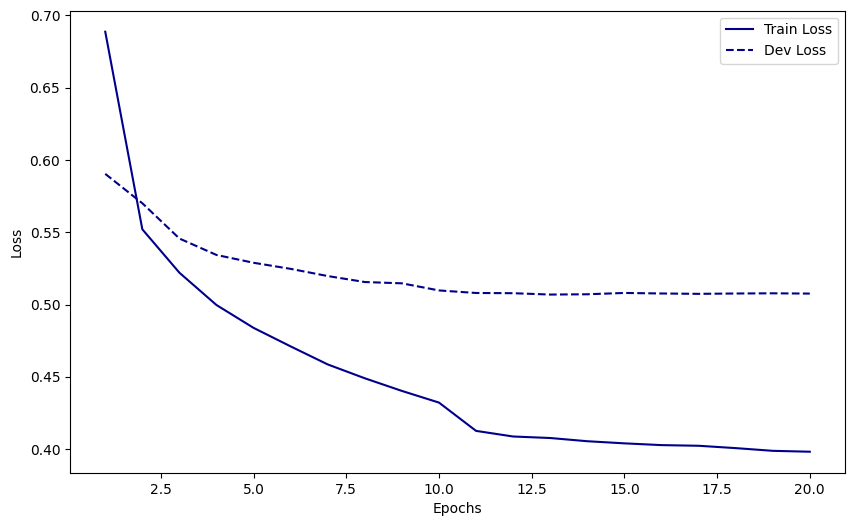

Classification Report for ShallowPOS_BiGRU:
              precision    recall  f1-score   support

         ADJ       0.91      0.90      0.91      1794
         ADP       0.84      0.76      0.80      2030
         ADV       0.93      0.86      0.89      1183
         AUX       0.97      0.96      0.97      1543
       CCONJ       0.76      0.32      0.45       736
         DET       0.88      0.79      0.83      1896
        INTJ       0.92      0.74      0.82       121
        NOUN       0.91      0.90      0.90      4123
         NUM       0.65      0.48      0.56       542
        PART       0.68      0.59      0.63       649
        PRON       0.97      0.97      0.97      2166
       PROPN       0.91      0.81      0.85      2076
       PUNCT       0.59      0.90      0.71      3096
       SCONJ       0.82      0.66      0.73       384
         SYM       0.96      0.61      0.74       109
        VERB       0.93      0.92      0.92      2606
           X       0.20      0.02    

In [ ]:
print("Training Shallow BiGRU RNN:")
shallow_bigrun_model = train_and_evaluate_rnn(ShallowPOS_BiGRU, input_dim=2*word2vec.vector_size, hidden_dim=128, output_dim=len(set([f[1] for f in train_features])), num_epochs=20)

Training Somewhat Deep BiGRU RNN:
Epoch 1/20, Train Loss: 0.7022546846293019, Dev Loss: 0.5867635689881212
Epoch 2/20, Train Loss: 0.5667467373823074, Dev Loss: 0.5607323512472305
Epoch 3/20, Train Loss: 0.5355007804888793, Dev Loss: 0.5470747769924632
Epoch 4/20, Train Loss: 0.5163764904924496, Dev Loss: 0.5313968856009027
Epoch 5/20, Train Loss: 0.4987494789519525, Dev Loss: 0.5240710062117206
Epoch 6/20, Train Loss: 0.4859537860313045, Dev Loss: 0.5268476989334986
Epoch 7/20, Train Loss: 0.47321452441555695, Dev Loss: 0.5183539290475965
Epoch 8/20, Train Loss: 0.46294248138149996, Dev Loss: 0.5155142432540879
Epoch 9/20, Train Loss: 0.45372238668249004, Dev Loss: 0.5186465924843809
Epoch 10/20, Train Loss: 0.4451829866587269, Dev Loss: 0.5136722904772388
Epoch 11/20, Train Loss: 0.4223506854107308, Dev Loss: 0.5125919201021505
Epoch 12/20, Train Loss: 0.4175819735985578, Dev Loss: 0.5130881210018817
Epoch 13/20, Train Loss: 0.4148119417116405, Dev Loss: 0.5125126642242709
Epoch 14/2

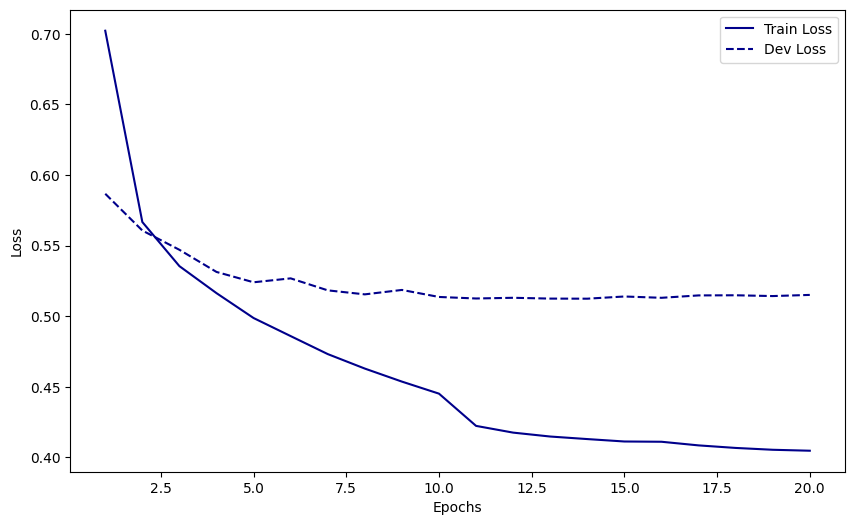

Classification Report for DeepPOS_BiGRU:
              precision    recall  f1-score   support

         ADJ       0.91      0.91      0.91      1794
         ADP       0.84      0.76      0.80      2030
         ADV       0.94      0.85      0.89      1183
         AUX       0.97      0.96      0.97      1543
       CCONJ       0.83      0.31      0.45       736
         DET       0.89      0.78      0.83      1896
        INTJ       0.93      0.69      0.80       121
        NOUN       0.91      0.90      0.90      4123
         NUM       0.66      0.49      0.56       542
        PART       0.68      0.61      0.65       649
        PRON       0.96      0.97      0.97      2166
       PROPN       0.91      0.81      0.86      2076
       PUNCT       0.58      0.91      0.71      3096
       SCONJ       0.80      0.70      0.74       384
         SYM       0.96      0.61      0.74       109
        VERB       0.93      0.92      0.92      2606
           X       0.00      0.00      0

In [ ]:
print("Training Somewhat Deep BiGRU RNN:")
somewhat_deep_bigrun_model = train_and_evaluate_rnn(DeepPOS_BiGRU, input_dim=2*word2vec.vector_size, hidden_dim=128, output_dim=len(set([f[1] for f in train_features])), num_epochs=20)

Training Very Deep BiGRU RNN:
Epoch 1/20, Train Loss: 0.7415308893886593, Dev Loss: 0.6143699082216822
Epoch 2/20, Train Loss: 0.5946611025962585, Dev Loss: 0.5762313990888739
Epoch 3/20, Train Loss: 0.5588858117699771, Dev Loss: 0.5607933800919611
Epoch 4/20, Train Loss: 0.5382228776389173, Dev Loss: 0.5455909664544246
Epoch 5/20, Train Loss: 0.5208595192831854, Dev Loss: 0.5391640282588495
Epoch 6/20, Train Loss: 0.5071301893863213, Dev Loss: 0.5371348662558654
Epoch 7/20, Train Loss: 0.4958442723432612, Dev Loss: 0.525490907088557
Epoch 8/20, Train Loss: 0.4843710587372045, Dev Loss: 0.5296513514411181
Epoch 9/20, Train Loss: 0.4747367534254936, Dev Loss: 0.5240084873255632
Epoch 10/20, Train Loss: 0.46566733328592197, Dev Loss: 0.5202993790159249
Epoch 11/20, Train Loss: 0.4445159603381982, Dev Loss: 0.513571013782855
Epoch 12/20, Train Loss: 0.4370920961473075, Dev Loss: 0.5127045885662088
Epoch 13/20, Train Loss: 0.4349677289771106, Dev Loss: 0.5127411887311099
Epoch 14/20, Train

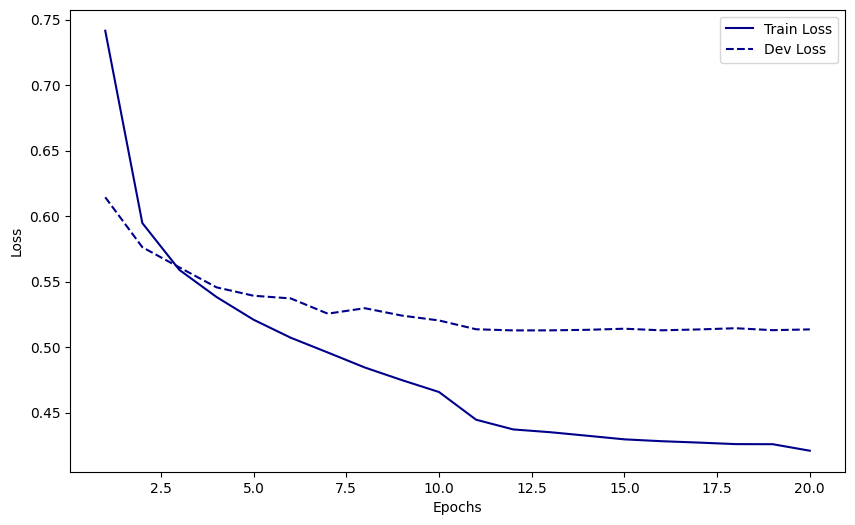

Classification Report for VeryDeepPOS_BiGRU:
              precision    recall  f1-score   support

         ADJ       0.91      0.91      0.91      1794
         ADP       0.84      0.75      0.79      2030
         ADV       0.94      0.86      0.90      1183
         AUX       0.96      0.97      0.96      1543
       CCONJ       0.71      0.34      0.46       736
         DET       0.89      0.79      0.83      1896
        INTJ       0.93      0.76      0.84       121
        NOUN       0.92      0.89      0.90      4123
         NUM       0.66      0.50      0.57       542
        PART       0.65      0.63      0.64       649
        PRON       0.96      0.98      0.97      2166
       PROPN       0.89      0.81      0.85      2076
       PUNCT       0.59      0.89      0.71      3096
       SCONJ       0.80      0.69      0.74       384
         SYM       0.93      0.61      0.73       109
        VERB       0.92      0.92      0.92      2606
           X       0.14      0.02   

In [ ]:
print("Training Very Deep BiGRU RNN:")
very_deep_bigrun_model = train_and_evaluate_rnn(VeryDeepPOS_BiGRU, input_dim=2*word2vec.vector_size, hidden_dim=128, output_dim=len(set([f[1] for f in train_features])), num_epochs=20)

## Choice of Architectures for Shallow, Somewhat Deep, and Deep RNNs



The design of the three RNN models (shallow, somewhat deep, and deep) was driven by the goal of maintaining a similar structure to the original MLP models while utilizing recurrent layers (GRU or LSTM) to capture temporal dependencies. The architectures were chosen based on the depth and complexity of the original MLP models, with the following considerations:

---

#### 1. **Shallow Bidirectional RNN (ShallowPOS_BiGRU)**

- **Depth**: The original shallow MLP contained only a single hidden layer. To maintain a similar structure in the RNN, we opted for **one bidirectional RNN layer**.
- **Bidirectional Nature**: The bidirectional RNN (using GRU or LSTM) processes the sequence in both directions (forward and backward), capturing context from both past and future words. This enriches the representation without increasing the depth of the model.
- **Output Layer**: Since the task is POS tagging, we use the final hidden state of the sequence for classification. We take the output of the last timestep from the bidirectional RNN as the representation of the input sequence, which is passed through a final linear layer for POS tagging.
- **Regularization**: Dropout is included after the RNN layer to prevent overfitting, keeping the model simple and regularized.


---

#### 2. **Somewhat Deep Bidirectional RNN (DeepPOS_BiGRU)**

- **Depth**: The original somewhat deep MLP contained two hidden layers, and we retained the concept of depth by adding **two bidirectional RNN layers**.
- **Bidirectional Nature**: Just like the shallow model, the bidirectional RNN layers help capture both past and future context. With two layers, the model can learn richer representations of the input sequence.
- **Regularization**: Dropout is applied after each RNN layer, just like the original MLP’s design, to prevent overfitting while maintaining simplicity.
- **Output Layer**: Similar to the shallow model, we take the final hidden state from the last timestep after the second RNN layer as the representation for POS tagging.


---

#### 3. **Very Deep Bidirectional RNN (VeryDeepPOS_BiGRU)**

- **Depth**: The original very deep MLP had **three hidden layers**. To replicate this depth in the RNN model, we used **three bidirectional RNN layers**.
- **Bidirectional Nature**: With three bidirectional RNN layers, the model learns contextual information from both the past and the future at multiple levels of abstraction.
- **Regularization**: Dropout is applied after each RNN layer to reduce the risk of overfitting and ensure that the model generalizes well.
- **Output Layer**: As in the shallower models, the last timestep of the final RNN layer is used for classification, which provides the most relevant representation of the entire sequence.


---


Each RNN architecture was designed to match the depth and structure of the original MLP models while incorporating the ability of recurrent layers to capture sequential dependencies. The bidirectional nature of the RNNs enhances the model's performance by considering both past and future contexts for each input sequence.

| **Model**                | **Accuracy** | **Macro avg F1-score** | **Weighted avg F1-score** | **Strengths**                                                                                                                                     | **Weaknesses**                                                                                                             |
|--------------------------|--------------|------------------------|---------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------|
| **ShallowPOS_MLP**        | 0.83         | 0.74                   | 0.83                      | High performance on **PRON (0.97 precision)**, **AUX (0.96 recall)**, and **VERB (0.91 f1-score)**.                                               | Struggles with **X (f1 = 0.00)** and **CCONJ (0.45 f1)**.                                                                |
| **DeepPOS_MLP**          | 0.83         | 0.74                   | 0.83                      | Improved recall for **AUX (0.94)** and **PRON (0.97)**, maintains strong performance across categories.                                           | Struggles with rare categories like **X**.                                                                                 |
| **VeryDeepPOS_MLP**      | 0.82         | 0.74                   | 0.82                      | Strong performance on **AUX** and **PRON**, but slightly lower overall performance compared to other MLP models.                                  | Some decrease in performance, especially in **CCONJ (0.43 f1)** and **NUM (0.56 f1)**.                                     |
| **ShallowPOS_BiGRU**     | 0.84         | 0.75                   | 0.84                      | High performance on **PRON (0.97 precision)**, **AUX (0.97 recall)**, and **VERB (0.92 f1-score)**.                                               | Struggles with **X (f1 = 0.04)** and **CCONJ (0.45 f1)**.                                                                |
| **DeepPOS_BiGRU**       | 0.84         | 0.75                   | 0.84                      | High performance on **AUX (0.97)** and **PRON (0.97)**.                                                                                          | Struggles with **X** and **CCONJ (0.45 f1)**.                                                                             |
| **VeryDeepPOS_BiGRU**   | 0.84         | 0.76                   | 0.84                      | Strong performance on **AUX (0.97)**, **PRON (0.98)**, and **VERB (0.92)** with a good balance across categories.                                | Some degradation in performance for **CCONJ (0.46 f1)** and **NUM (0.57 f1)**, but more consistent than previous models.  |

---

### **Comparison:**

- **Accuracy:** Both the MLP and BiGRU models generally perform similarly in terms of accuracy (ranging from **0.82 to 0.84**).
- **F1 Scores:** The BiGRU models tend to outperform the MLP models slightly in terms of both macro and weighted average F1 scores, with values like **0.75 (macro avg)** and **0.84 (weighted avg)** compared to the MLP's **0.74 (macro avg)** and **0.83 (weighted avg)**.
- **Category Performance:** Both MLP and RNN models show consistent strength in categories like **PRON** and **AUX**, but also share similar weaknesses in rare categories like **X** and **CCONJ**.
- **Deepness & Performance Trade-off:** Moving from shallow to deep MLP models generally resulted in small drops in accuracy and macro F1, suggesting diminishing returns with deeper layers. However, the BiGRU models show slight improvements in their macro and weighted F1 scores despite being deep.


## Baseline Tagger

In [ ]:
class BaselineTagger:
    def __init__(self, train_data):
        """
        Initializes the baseline tagger. It trains on the given training data
        by counting the most frequent tag for each word.
        """
        self.word_to_tag = defaultdict(lambda: None)  # Default None for unseen words
        self.most_frequent_tag = None
        self.train(train_data)

    def train(self, train_data):
        """
        Trains the baseline tagger by recording the most frequent tag for each word.
        """
        word_tag_counts = defaultdict(lambda: defaultdict(int))  # Count tags per word

        # Count occurrences of each word-tag pair in the training data
        for sentence in train_data:
            for word, tag in sentence:
                word_tag_counts[word][tag] += 1

        # For each word, find the most frequent tag
        for word, tag_counts in word_tag_counts.items():
            self.word_to_tag[word] = max(tag_counts, key=tag_counts.get)

        # Find the most frequent tag overall in the training data (for unseen words)
        tag_counts = defaultdict(int)
        for sentence in train_data:
            for _, tag in sentence:
                tag_counts[tag] += 1

        # Set the most frequent tag to handle unseen words
        self.most_frequent_tag = max(tag_counts, key=tag_counts.get)

    def predict(self, sentence):
        """
        Predicts the tags for the given sentence using the baseline strategy.
        For each word, it returns the most frequent tag it has in the training data,
        or the most frequent tag overall if the word is unseen.
        """
        return [self.word_to_tag.get(word, self.most_frequent_tag) for word, _ in sentence]

    def evaluate(self, test_data):
        """
        Evaluates the baseline tagger on the given test data and prints precision, recall, F1,
        and AUC scores.
        """
        y_true = []
        y_pred = []
        y_prob = []

        for sentence in test_data:
            true_tags = [tag for _, tag in sentence]
            predicted_tags = self.predict(sentence)

            y_true.extend(true_tags)
            y_pred.extend(predicted_tags)

        # Convert numeric labels to POS tags using idx_to_tag
        y_true_tags = [tag_to_idx[idx] for idx in y_true]
        y_pred_tags = [tag_to_idx[idx] for idx in y_pred]

        # Classification report with tags instead of numeric class labels
        print(f"Baseline Tagger Classification Report:")
        print(classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, zero_division=0))

        # Calculate AUC scores for each class
        auc_scores = {}
        for i, tag in enumerate(pos_tags):
            # One-hot encode the true labels for the current tag
            true_binary = [1 if label == i else 0 for label in y_true_tags]
            pred_binary = [1 if label == i else 0 for label in y_pred_tags]
            auc_score = roc_auc_score(true_binary, pred_binary)
            auc_scores[tag] = auc_score

        # Print AUC scores for each class
        print("\nAUC Scores for Each Class:")
        for tag, auc in auc_scores.items():
            print(f"{tag}: {auc:.4f}")

        # Calculate Macro-Averaged Precision, Recall, F1, and Precision-Recall AUC
        report = classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, output_dict=True, zero_division=0)
        precision_macro = report["macro avg"]["precision"]
        recall_macro = report["macro avg"]["recall"]
        f1_macro = report["macro avg"]["f1-score"]

        # Precision-Recall AUC (macro-average)
        precision_recall_auc_macro = np.mean([roc_auc_score([1 if label == i else 0 for label in y_true_tags],
                                                           [1 if label == i else 0 for label in y_pred_tags]) for i in range(len(pos_tags))])

        # Print Macro-Averaged Metrics
        print(f"\nMacro-Averaged Precision: {precision_macro:.4f}")
        print(f"Macro-Averaged Recall: {recall_macro:.4f}")
        print(f"Macro-Averaged F1: {f1_macro:.4f}")
        print(f"Macro-Averaged Precision-Recall AUC: {precision_recall_auc_macro:.4f}")


In [ ]:
# Train the baseline tagger
baseline_tagger = BaselineTagger(train_data)

# Evaluate on the test set
baseline_tagger.evaluate(test_data)


Baseline Tagger Classification Report:
              precision    recall  f1-score   support

         ADJ       0.91      0.83      0.87      1794
         ADP       0.87      0.88      0.88      2030
         ADV       0.94      0.79      0.86      1183
         AUX       0.93      0.89      0.91      1543
       CCONJ       0.99      1.00      0.99       736
         DET       0.96      0.97      0.96      1896
        INTJ       0.97      0.69      0.80       121
        NOUN       0.67      0.93      0.78      4123
         NUM       0.91      0.61      0.73       542
        PART       0.69      0.99      0.81       649
        PRON       0.96      0.93      0.95      2166
       PROPN       0.91      0.51      0.66      2076
       PUNCT       0.99      0.99      0.99      3096
       SCONJ       0.62      0.60      0.61       384
         SYM       0.81      0.83      0.82       109
        VERB       0.89      0.82      0.85      2606
           X       1.00      0.00      0.0

## Dataset Statistics

In [ ]:
def compute_statistics(data):
    """
    Computes various statistics about the dataset (train, dev, or test).
    Focuses on word-level statistics.
    """
    total_words = 0
    word_lengths = []
    pos_tags = []
    word_set = set()
    tag_counts = Counter()

    for sentence in data:
        total_words += len(sentence)

        for word, tag in sentence:
            word_set.add(word)  # Add word to vocabulary set
            word_lengths.append(len(word))  # Word length for average calculation
            pos_tags.append(tag)  # Collect POS tags
            tag_counts[tag] += 1  # Count frequency of POS tags

    avg_word_length = np.mean(word_lengths)
    vocab_size = len(word_set)
    unique_pos_tags = len(set(pos_tags))

    most_frequent_tag = tag_counts.most_common(1)[0]  # Most frequent POS tag
    most_frequent_tag_name = most_frequent_tag[0]
    most_frequent_tag_count = most_frequent_tag[1]

    # Print the statistics
    print(f"Total number of words: {total_words}")
    print(f"Vocabulary size: {vocab_size}")
    print(f"Average word length: {avg_word_length:.2f} characters")
    print(f"Number of unique POS tags: {unique_pos_tags}")

    # Most frequent POS tag
    print(f"Most frequent POS tag: {most_frequent_tag_name} (occurred {most_frequent_tag_count} times)")

    print("\nPOS tag distribution:")
    for tag, count in sorted(tag_counts.items()):
        print(f"{tag}: {count} occurrences")

# Calculate statistics for train, dev, and test datasets
print("Training Data Statistics:")
compute_statistics(train_data)

print("\nDevelopment Data Statistics:")
compute_statistics(dev_data)

print("\nTest Data Statistics:")
compute_statistics(test_data)


Training Data Statistics:
Total number of words: 207230
Vocabulary size: 20201
Average word length: 4.08 characters
Number of unique POS tags: 18
Most frequent POS tag: NOUN (occurred 34755 times)

POS tag distribution:
ADJ: 13187 occurrences
ADP: 17745 occurrences
ADV: 10117 occurrences
AUX: 12818 occurrences
CCONJ: 6687 occurrences
DET: 16299 occurrences
INTJ: 695 occurrences
NOUN: 34755 occurrences
NUM: 4127 occurrences
PART: 5748 occurrences
PRON: 18677 occurrences
PROPN: 12618 occurrences
PUNCT: 23596 occurrences
SCONJ: 3822 occurrences
SYM: 722 occurrences
VERB: 22604 occurrences
X: 399 occurrences
_: 2614 occurrences

Development Data Statistics:
Total number of words: 25512
Vocabulary size: 5638
Average word length: 4.14 characters
Number of unique POS tags: 18
Most frequent POS tag: NOUN (occurred 4212 times)

POS tag distribution:
ADJ: 1873 occurrences
ADP: 2039 occurrences
ADV: 1224 occurrences
AUX: 1567 occurrences
CCONJ: 779 occurrences
DET: 1900 occurrences
INTJ: 115 occu

## Methods and Datasets



We developed a **Part-of-Speech (POS) tagger** using a variety of **Recurrent Neural Network (RNN)** architectures, using either **Bidirectional GRU** or **LSTM** models. In all cases, **Word2Vec embeddings** were used as input features. The model was evaluated on the **English Universal Dependencies Treebank** (UD_English-EWT), which contains labeled data for training, development, and testing.

The models were evaluated on several performance metrics such as **accuracy**, **precision**, **recall**, **F1-score**, and **AUC scores**.

### Datasets:
- **Training**: en_ewt-ud-train.conllu
- **Development**: en_ewt-ud-dev.conllu
- **Test**: en_ewt-ud-test.conllu

The data was parsed and preprocessed to extract **words** and their corresponding **POS tags**.

### Preprocessing Steps

1. **Tokenization**:
   - We parsed the **conllu** files to extract each word and its associated POS tag.

2. **Word2Vec Embeddings**:
   - Pre-trained **Word2Vec** embeddings were used to represent words as vectors. This allows us to capture semantic relationships between words.

3. **Model**:
   - We trained various models, including:
     - **Bidirectional RNN with GRU/LSTM cells**: These architectures were developed to capture sequential dependencies in the data. The models had variety in their depth. Bidirectional GRU/LSTM cells were used to capture both past and future context in the sentence. Dropout was applied as a regularization technique.
     - **Comparison of Performance**: We compared different model architectures—**Shallow RNN**, **Deep RNN**, and **Very Deep RNN** with the previous best MLP performer.

4. **Evaluation**:
   - The performance of the models was evaluated on **accuracy**, **precision**, **recall**, **F1-score**, and **AUC scores**, with metrics computed separately for each POS tag and averaged across tags.